In [29]:
import pandas as pd
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import chi2

In [2]:

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

# Load the datasets
news_df = pd.read_csv('./data/us_equities_news_dataset.csv')
stock_df = pd.read_csv('./data/NVDA.csv')

In [4]:

# Convert the date columns to datetime format for matching
news_df['Date'] = pd.to_datetime(news_df['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge news data with stock prices based on publication date
merged_df = pd.merge(news_df, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
filtered_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(filtered_df.head())


Filtered and Labeled Data:
                                             content     Open    Close  \
0  What s happening\nShares of Chinese electric c...  6.19475  6.13925   
1  Gainers  NIO  NYSE NIO   14   Village Farms In...  6.19475  6.13925   
2  Cemtrex  NASDAQ CETX   85  after FY results \n...  6.19475  6.13925   
3  aTyr Pharma  NASDAQ LIFE   63  on Kyorin Pharm...  5.80800  5.92650   
4  Gainers  NIO  NYSE NIO   14   Meritor  NYSE MT...  5.77250  5.88250   

        Date  target  
0 2020-01-15       0  
1 2020-01-15       0  
2 2020-01-15       0  
3 2020-01-06       1  
4 2019-12-31       1  


C:\Users\georg\AppData\Local\Temp\ipykernel_23280\260194063.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)


In [5]:

# Proceed with the rest of your analysis using filtered_df
# Basic descriptive statistics for the news dataset
num_articles = filtered_df.shape[0]
average_words_per_article = filtered_df['content'].apply(lambda x: len(str(x).split())).mean()
print(f"The number of articles is: {num_articles}")
print(f"The average amount of words per article is: {average_words_per_article}")

The number of articles is: 197393
The average amount of words per article is: 579.1646714929101


In [6]:

# Tokenize content for word frequency analysis
filtered_df.loc[:, 'text_length'] = filtered_df['content'].apply(lambda x: len(str(x).split()))

C:\Users\georg\AppData\Local\Temp\ipykernel_23280\2432952274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_text'] = filtered_df['content'].apply(lambda x: word_tokenize(str(x).lower()))


In [7]:
# Remove stopwords and punctuation for better NLP insights
stop_words = set(stopwords.words('english'))
filtered_df.loc[:, 'filtered_text'] = filtered_df['processed_text'].apply(
    lambda words: [word for word in words if word.isalpha() and word not in stop_words])

C:\Users\georg\AppData\Local\Temp\ipykernel_23280\3475452813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_text'] = filtered_df['processed_text'].apply(


In [8]:

# Join the filtered words back into strings for TF-IDF
filtered_df.loc[:, 'filtered_text_str'] = filtered_df['filtered_text'].apply(lambda x: ' '.join(x))

C:\Users\georg\AppData\Local\Temp\ipykernel_23280\1618671758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_text_str'] = filtered_df['filtered_text'].apply(lambda x: ' '.join(x))


In [9]:

# Frequency analysis of the most common words
all_words = [word for content in filtered_df['filtered_text'] for word in content]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(50)

# Display the most common words in the news dataset
print("\nTop 50 most common words in the news articles (after stop word removal):")
print(most_common_words)


Top 50 most common words in the news articles (after stop word removal):
[('year', 690321), ('company', 528034), ('zacks', 467746), ('earnings', 465774), ('quarter', 391328), ('million', 326965), ('said', 320598), ('nyse', 305298), ('market', 300428), ('stocks', 293614), ('growth', 292174), ('billion', 280832), ('u', 274978), ('stock', 266056), ('also', 260139), ('nasdaq', 250140), ('new', 227672), ('inc', 222843), ('rank', 217936), ('last', 217261), ('expected', 195749), ('per', 194272), ('percent', 189412), ('investors', 185476), ('estimate', 184859), ('share', 183860), ('sales', 179224), ('consensus', 174616), ('shares', 173841), ('price', 168608), ('one', 166523), ('would', 150963), ('first', 149964), ('buy', 147672), ('companies', 146162), ('revenues', 146124), ('time', 145588), ('may', 144504), ('p', 142066), ('higher', 141780), ('see', 139816), ('could', 138099), ('strong', 135474), ('industry', 132372), ('business', 128143), ('report', 127785), ('week', 126720), ('reported', 1

In [11]:
# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Reduced max features
tfidf_matrix = vectorizer.fit_transform(filtered_df['filtered_text_str'])

In [30]:
# Train a linear classifier (e.g., Logistic Regression) on the TF-IDF matrix
clf = LogisticRegression(max_iter=1000)
clf.fit(tfidf_matrix, filtered_df['target'])

LogisticRegression(max_iter=1000)

In [32]:
def print_top_features(vectorizer, clf):
    """Prints features with the highest coefficient values for binary classification."""
    feature_names = vectorizer.get_feature_names_out()
    coef = clf.coef_[0]  # Use the first (and only) set of coefficients for binary classification
    
    # Top 20 features with the most negative coefficients (indicative of Class 0)
    top_features_class_0 = np.argsort(coef)[:20]
    print("\nTop 20 Words Indicative of Class 0 (Stock Price Down):")
    print(" ".join(feature_names[j] for j in top_features_class_0))
    
    # Top 20 features with the most positive coefficients (indicative of Class 1)
    top_features_class_1 = np.argsort(coef)[-20:]
    print("\nTop 20 Words Indicative of Class 1 (Stock Price Up):")
    print(" ".join(feature_names[j] for j in top_features_class_1))

# Print the most informative features for binary classification
print_top_features(vectorizer, clf)



Top 20 Words Indicative of Class 0 (Stock Price Down):
fell dropped future lost september factors grow single recent tech annual soon august com friday addition adjusted research loss trade

Top 20 Words Indicative of Class 1 (Stock Price Up):
segment europe carries rank investments january esp gains july say release coming core amzn monday expects impact gained fourth rose


In [34]:
# Correct function to print top informative features for binary classification
def print_top_features(vectorizer, coef):
    """Prints features with the highest coefficient values for binary classification."""
    feature_names = vectorizer.get_feature_names_out()
    
    # Top 20 features with the most negative coefficients (indicative of Class 0)
    top_features_class_0 = np.argsort(coef)[:20]
    print("\nTop 20 Words Indicative of Class 0 (Stock Price Down):")
    print(" ".join(feature_names[j] for j in top_features_class_0))
    
    # Top 20 features with the most positive coefficients (indicative of Class 1)
    top_features_class_1 = np.argsort(coef)[-20:]
    print("\nTop 20 Words Indicative of Class 1 (Stock Price Up):")
    print(" ".join(feature_names[j] for j in top_features_class_1))
    
    return top_features_class_0, top_features_class_1

# Extract the coefficients from the classifier
coef = clf.coef_[0]

# Print the most informative features and get the indices for visualization
top_features_class_0, top_features_class_1 = print_top_features(vectorizer, coef)


Top 20 Words Indicative of Class 0 (Stock Price Down):
fell dropped future lost september factors grow single recent tech annual soon august com friday addition adjusted research loss trade

Top 20 Words Indicative of Class 1 (Stock Price Up):
segment europe carries rank investments january esp gains july say release coming core amzn monday expects impact gained fourth rose


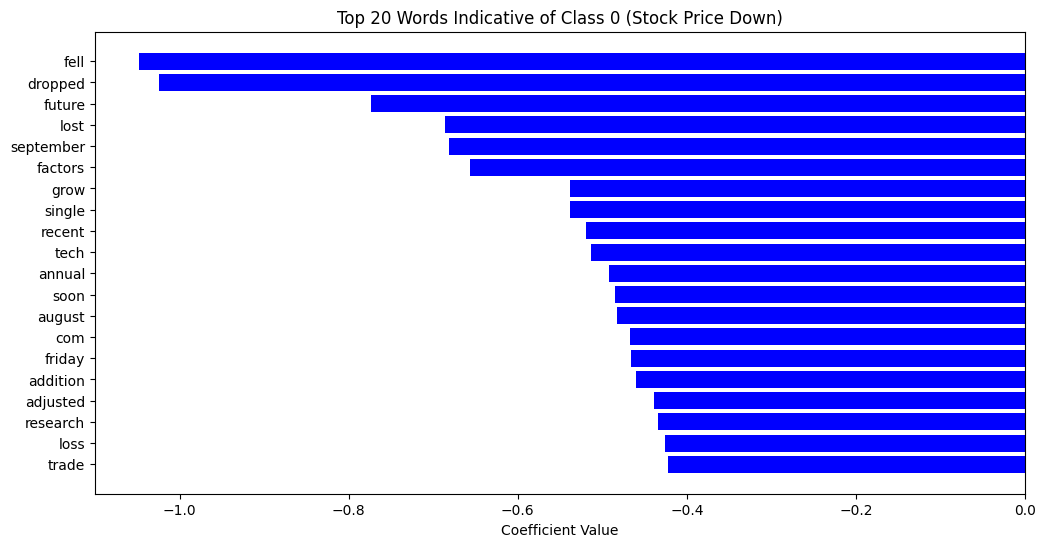

In [36]:

# Visualize the top features for Class 0 (Stock Price Down)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_0], coef[top_features_class_0], color='blue')
plt.title('Top 20 Words Indicative of Class 0 (Stock Price Down)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()



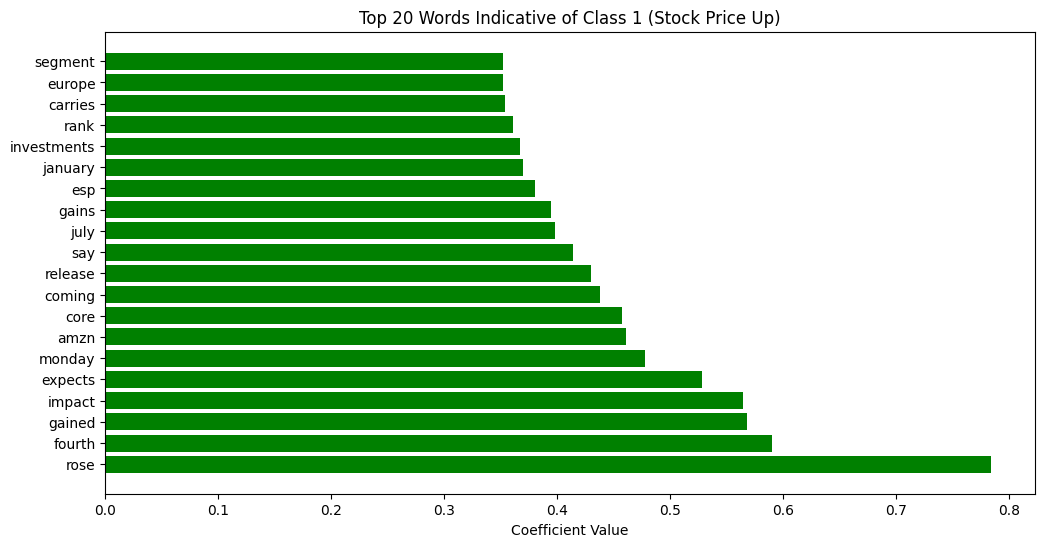

In [37]:
# Visualize the top features for Class 1 (Stock Price Up)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_1], coef[top_features_class_1], color='green')
plt.title('Top 20 Words Indicative of Class 1 (Stock Price Up)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()

In [ ]:

# Compute cosine similarity matrix, which measures the similarity between documents
# Source: https://medium.com/@anurag-jain/tf-idf-vectorization-with-cosine-similarity-eca3386d4423
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix)

In [13]:

# Find indices of the most and least similar documents (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0)
most_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
least_similar_indices = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)

NameError: name 'similarity_matrix' is not defined

In [0]:

# Inspect the most similar documents
similar_doc_1 = news_df.iloc[most_similar_indices[0]]
similar_doc_2 = news_df.iloc[most_similar_indices[1]]

print("\nMost Similar Documents:\n")
print("Document 1:")
print(similar_doc_1['content'])
print("\nDocument 2:")
print(similar_doc_2['content'])

In [10]:

# Inspect the least similar documents
dissimilar_doc_1 = news_df.iloc[least_similar_indices[0]]
dissimilar_doc_2 = news_df.iloc[least_similar_indices[1]]

print("\n\nMost Dissimilar Documents:\n")
print("Document 1:")
print(dissimilar_doc_1['content'])
print("\nDocument 2:")
print(dissimilar_doc_2['content'])



'\n\n# TF-IDF Representation of Documents using the processed and filtered text\nvectorizer = TfidfVectorizer(stop_words=\'english\', max_features=10)\ntfidf_matrix = vectorizer.fit_transform(news_df[\'filtered_text_str\'])\n\n# Compute cosine similarity matrix\nsimilarity_matrix = cosine_similarity(tfidf_matrix)\n\n# Convert similarity matrix to a DataFrame for easier handling\nsimilarity_df = pd.DataFrame(similarity_matrix)\n\n# Find indices of the most and least similar documents (excluding self-similarity)\nnp.fill_diagonal(similarity_matrix, 0)\nmost_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)\nleast_similar_indices = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)\n\n# Inspect the most similar documents\nsimilar_doc_1 = news_df.iloc[most_similar_indices[0]]\nsimilar_doc_2 = news_df.iloc[most_similar_indices[1]]\n\nprint("\nMost Similar Documents:\n")\nprint("Document 1:")\nprint(similar_do